In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from colokroll import ImageLoader
from colokroll.imaging_preprocessing import find_oof_slices

In [14]:
IMAGE_PATH = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_ctrl_5.ome.tiff")

loader = ImageLoader()
stack = loader.load_image(IMAGE_PATH)
print(f"Loaded stack shape: {stack.shape}  (expected Z, Y, X, C)")
print(f"Channel names: {loader.get_channel_names() or 'N/A'}")

2025-11-04 15:27:25,534 - colokroll.data_processing.image_loader - INFO - Loaded metadata from converted TIFF: pixel_size=0.108333333333333μm
2025-11-04 15:27:29,967 - colokroll.data_processing.image_loader - INFO - Squeezed singleton dim(s): (19, 1800, 1800, 4, 1) -> (19, 1800, 1800, 4)
2025-11-04 15:27:29,967 - colokroll.data_processing.image_loader - INFO - Successfully loaded TIFF image with shape: (19, 1800, 1800, 4)


Loaded stack shape: (19, 1800, 1800, 4)  (expected Z, Y, X, C)
Channel names: ['AF647', 'AF568', 'AF488', 'DAPI']


In [15]:
new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
channel_names = loader.rename_channels(new_channel_names)

# AF488 -> ALIX, AF647 -> LAMP1, AF568 -> Phalloidin, DAPI -> DAPI


2025-11-04 15:27:36,567 - colokroll.data_processing.image_loader - INFO - Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [16]:
channel_names = loader.get_channel_names()
channel_names

['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']

In [17]:
result = find_oof_slices(
    stack,
    method="combined",        # Laplacian + Tenengrad
    aggregation="median",     # combine channels per slice
    strategy="relative",      # relative-to-median threshold
    threshold=0.6,            # tweak as needed
    smooth=3,                 # sliding window smoothing (odd)
    clip_percent=1.0,         # optional contrast clipping
)
print(f"In-focus slices: {result.indices_in_focus.tolist()}")
print(f"Out-of-focus count: {result.mask_oof.sum()} / {stack.shape[0]}")

In-focus slices: [0, 1, 12, 13, 14, 15, 16, 17, 18]
Out-of-focus count: 10 / 19


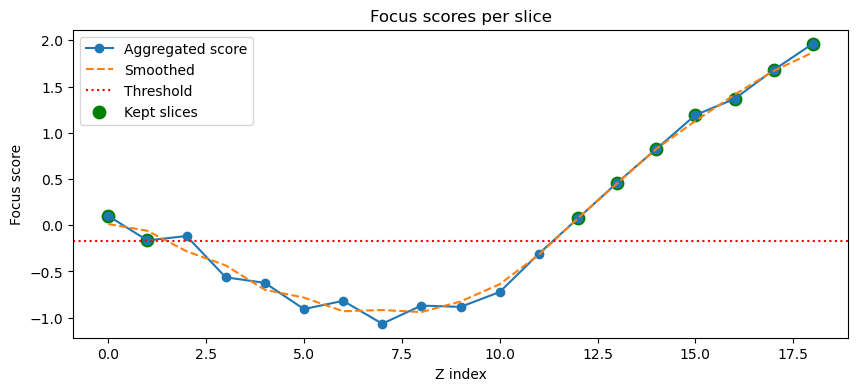

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
z_range = np.arange(stack.shape[0])

ax.plot(z_range, result.scores_agg, label="Aggregated score", marker="o")
ax.plot(z_range, result.smoothed_scores, label="Smoothed", linestyle="--")
ax.axhline(result.threshold_used, color="red", linestyle=":", label="Threshold")
ax.scatter(
    result.indices_in_focus,
    result.scores_agg[result.indices_in_focus],
    color="green",
    s=80,
    label="Kept slices",
)

ax.set_xlabel("Z index")
ax.set_ylabel("Focus score")
ax.set_title("Focus scores per slice")
ax.legend(loc="best")
plt.show()

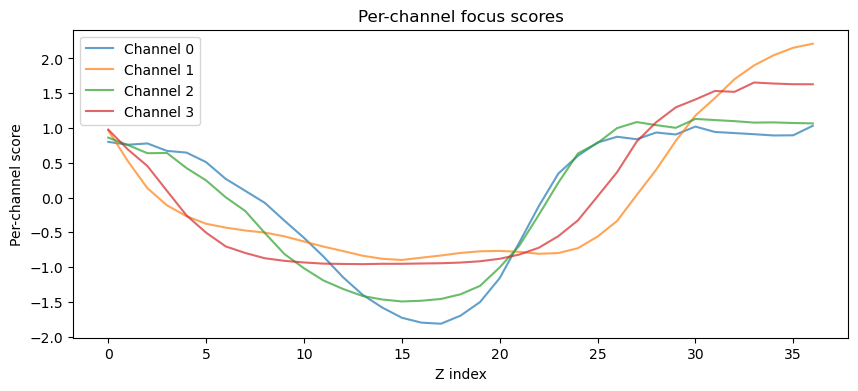

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
for ch in range(result.scores_zc.shape[1]):
    ax.plot(
        z_range,
        result.scores_zc[:, ch],
        label=f"Channel {ch}",
        alpha=0.7,
    )

ax.set_xlabel("Z index")
ax.set_ylabel("Per-channel score")
ax.set_title("Per-channel focus scores")
ax.legend(loc="best")
plt.show()

In [10]:
filtered_stack = stack[result.indices_in_focus]
print(f"Filtered stack shape: {filtered_stack.shape}")

# Example: collapse to MIP on the kept slices only
mip = filtered_stack.max(axis=0)
print(f"MIP shape: {mip.shape}")

Filtered stack shape: (18, 1800, 1800, 4)
MIP shape: (1800, 1800, 4)


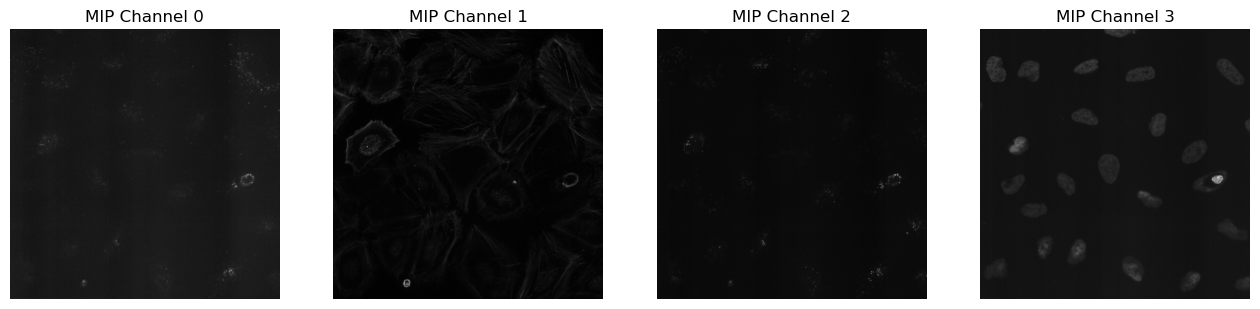

In [11]:
n_channels = filtered_stack.shape[-1]
fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))

if n_channels == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    ax.imshow(mip[:, :, idx], cmap="gray")
    ax.set_title(f"MIP Channel {idx}")
    ax.axis("off")

plt.show()

In [12]:
# assume `stack` is (Z, Y, X, C) and `result = find_oof_slices(...)`

kept_idx = result.indices_in_focus
removed_idx = np.where(result.mask_oof)[0]

kept_stack = stack[kept_idx] if kept_idx.size else None
removed_stack = stack[removed_idx] if removed_idx.size else None

def compute_mip(substack: np.ndarray | None) -> np.ndarray | None:
    if substack is None or substack.size == 0:
        return None
    return substack.max(axis=0)  # shape (Y, X, C)

mip_kept = compute_mip(kept_stack)
mip_removed = compute_mip(removed_stack)

print(f"MIPs computed. Kept slices: {kept_idx.size}, removed slices: {removed_idx.size}")

MIPs computed. Kept slices: 18, removed slices: 19


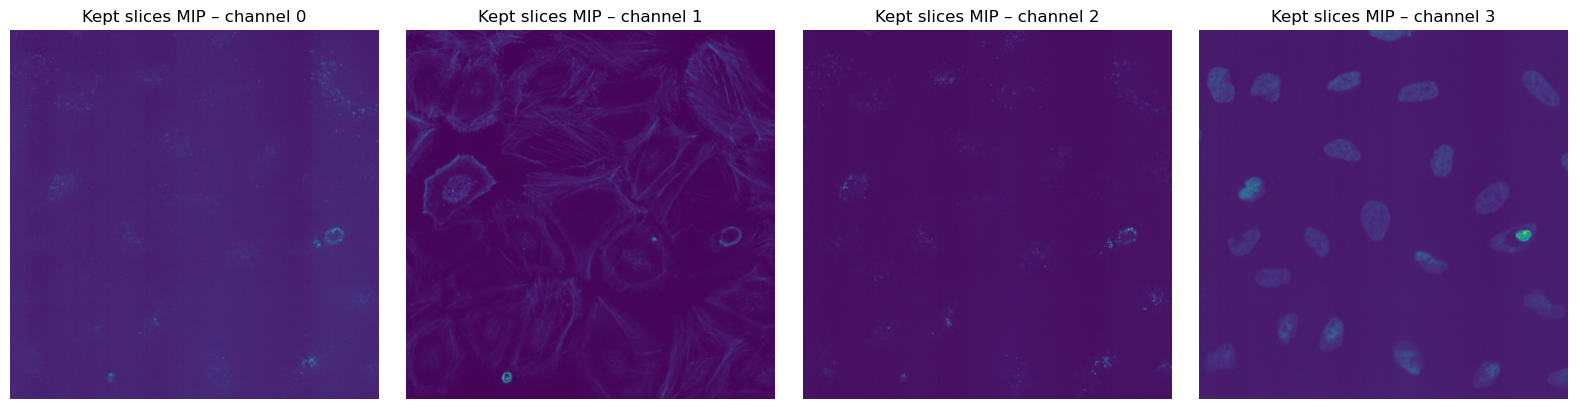

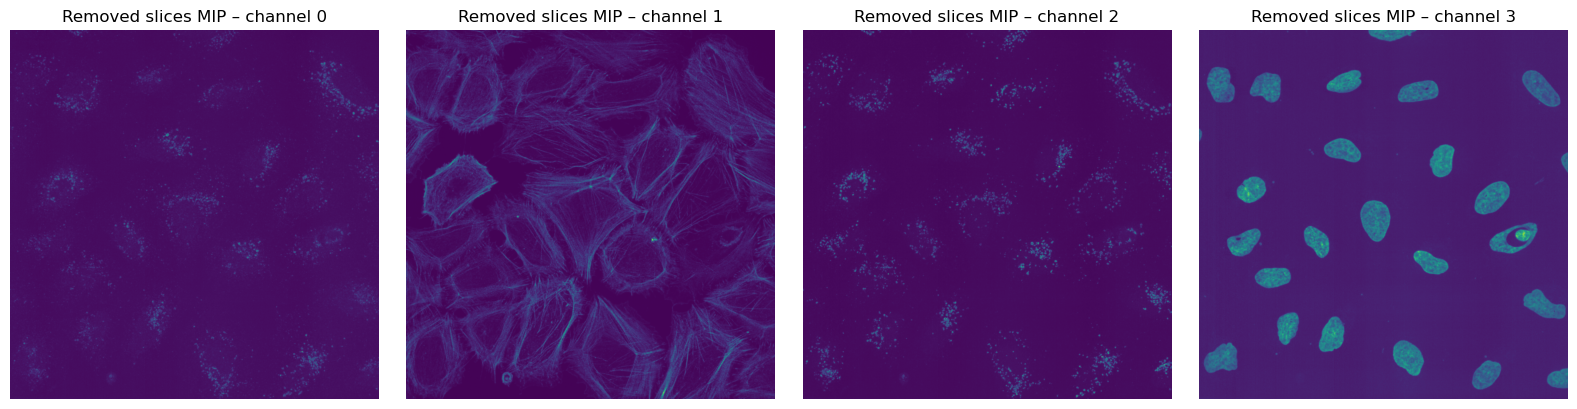

In [13]:
def show_mip(mip: np.ndarray, title: str) -> None:
    if mip is None:
        print(f"{title}: no data")
        return

    n_channels = mip.shape[-1]
    fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))
    if n_channels == 1:
        axes = [axes]

    for ch, ax in enumerate(axes):
        ax.imshow(mip[..., ch], cmap="viridis")
        ax.set_title(f"{title} – channel {ch}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_mip(mip_kept, "Kept slices MIP")
show_mip(mip_removed, "Removed slices MIP")

In [30]:
z = 4
plt.imshow(stack[result.removed_idx[z], :, :, 0], cmap="gray")  # pick channel 0

AttributeError: 'FocusDetectionResult' object has no attribute 'removed_idx'